Version 1.0.2

# Pandas basics 

Hi! In this programming assignment you need to refresh your `pandas` knowledge. You will need to do several [`groupby`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html)s and [`join`]()`s to solve the task. 

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 

from grader import Grader

In [4]:
DATA_FOLDER = '../readonly/final_project_data/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

The dataset we are going to use is taken from the competition, that serves as the final project for this course. You can find complete data description at the [competition web page](https://www.kaggle.com/c/competitive-data-science-final-project/data). To join the competition use [this link](https://www.kaggle.com/t/1ea93815dca248e99221df42ebde3540).

## Grading

We will create a grader instace below and use it to collect your answers. When function `submit_tag` is called, grader will store your answer *locally*. The answers will *not* be submited to the platform immediately so you can call `submit_tag` function as many times as you need. 

When you are ready to push your answers to the platform you should fill your credentials and run `submit` function in the <a href="#Authorization-&-Submission">last paragraph</a>  of the assignment.

In [5]:
grader = Grader()

# Task

Let's start with a simple task. 

<ol start="0">
  <li><b>Print the shape of the loaded dataframes and use [`df.head`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html) function to print several rows. Examine the features you are given.</b></li>
</ol>

In [6]:
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [7]:
transactions.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [8]:
transactions.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

Now use your `pandas` skills to get answers for the following questions. 
The first question is:

1. ** What was the maximum total revenue among all the shops in September, 2014?** 


* Hereinafter *revenue* refers to total sales minus value of goods returned.

*Hints:*

* Sometimes items are returned, find such examples in the dataset. 
* It is handy to split `date` field into [`day`, `month`, `year`] components and use `df.year == 14` and `df.month == 9` in order to select target subset of dates.
* You may work with `date` feature as with srings, or you may first convert it to `pd.datetime` type with `pd.to_datetime` function, but do not forget to set correct `format` argument.

In [9]:
filtered_trans = transactions[transactions.date.str.endswith('09.2014')]
filtered_trans['total_profit_or_loss'] = filtered_trans['item_price'] * filtered_trans['item_cnt_day']

max_revenue = filtered_trans.groupby('shop_id')['total_profit_or_loss'].sum().max()
grader.submit_tag('max_revenue', max_revenue)

Current answer for task max_revenue is: 7982852.2


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Great! Let's move on and answer another question:

<ol start="2">
  <li><b>What item category generated the highest revenue in summer 2014?</b></li>
</ol>

* Submit `id` of the category found.
    
* Here we call "summer" the period from June to August.

*Hints:*

* Note, that for an object `x` of type `pd.Series`: `x.argmax()` returns **index** of the maximum element. `pd.Series` can have non-trivial index (not `[1, 2, 3, ... ]`).

In [10]:
filtered_trans = transactions[transactions.date.str.match('.*0[6-8].2014$')]
filtered_trans = filtered_trans.join(items[['item_id', 'item_category_id']].set_index('item_id'), on='item_id', how='left')
filtered_trans['total_profit_or_loss'] = filtered_trans['item_price'] * filtered_trans['item_cnt_day']

category_id_with_max_revenue = filtered_trans.groupby('item_category_id')['total_profit_or_loss'].sum().argmax()
grader.submit_tag('category_id_with_max_revenue', category_id_with_max_revenue)

Current answer for task category_id_with_max_revenue is: 20


<ol start="3">
  <li><b>How many items are there, such that their price stays constant (to the best of our knowledge) during the whole period of time?</b></li>
</ol>

* Let's assume, that the items are returned for the same price as they had been sold.

In [11]:
unique_count = transactions.groupby('item_id')['item_price'].nunique()

num_items_constant_price = len(unique_count[unique_count == 1])
grader.submit_tag('num_items_constant_price', num_items_constant_price)

Current answer for task num_items_constant_price is: 5926


Remember, the data can sometimes be noisy.

<ol start="4">
  <li><b>What was the variance of the number of sold items per day sequence for the shop with `shop_id = 25` in December, 2014? Do not count the items, that were sold but returned back later.</b></li>
</ol>

* Fill `total_num_items_sold` and `days` arrays, and plot the sequence with the code below.
* Then compute variance. Remember, there can be differences in how you normalize variance (biased or unbiased estimate, see [link](https://math.stackexchange.com/questions/496627/the-difference-between-unbiased-biased-estimator-variance)). Compute ***unbiased*** estimate (use the right value for `ddof` argument in `pd.var` or `np.var`). 
* If there were no sales at a given day, ***do not*** impute missing value with zero, just ignore that day

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  import sys


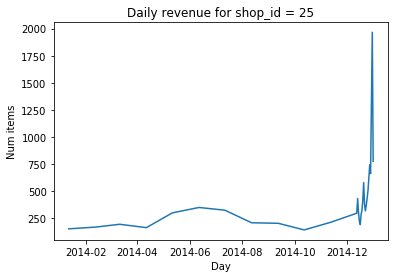

Current answer for task total_num_items_sold_var is: 117167.702299


In [23]:
shop_id = 25

filtered_trans = transactions[transactions.shop_id == shop_id]
filtered_trans = filtered_trans[filtered_trans.date.str.endswith('12.2014')]
filtered_trans = filtered_trans.groupby('date')['item_cnt_day'].sum()
total_num_items_sold = filtered_trans.values
days = filtered_trans.index.to_datetime()

# Plot it
plt.plot(days, total_num_items_sold)
plt.ylabel('Num items')
plt.xlabel('Day')
plt.title("Daily revenue for shop_id = 25")
plt.show()

total_num_items_sold_var = filtered_trans.var()
grader.submit_tag('total_num_items_sold_var', total_num_items_sold_var)

## Authorization & Submission
To submit assignment to Cousera platform, please, enter your e-mail and token into the variables below. You can generate token on the programming assignment page. *Note:* Token expires 30 minutes after generation.

In [24]:
STUDENT_EMAIL = ''
STUDENT_TOKEN = ''
grader.status()

You want to submit these numbers:
Task max_revenue: 7982852.2
Task category_id_with_max_revenue: 20
Task num_items_constant_price: 5926
Task total_num_items_sold_var: 117167.702299


In [25]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!


Well done! :)